# Red Blood Cell Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [1]:
import os
import sys
import random
import warnings
from os.path import isfile, join

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile
import datetime
import cv2

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../train/'
TEST_PATH = '../test/'

if not os.path.isdir(TRAIN_PATH):
    os.makedirs(TRAIN_PATH)

if not os.path.isdir(TEST_PATH):
    os.makedirs(TEST_PATH)


dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
print(tf.__version__)

2.4.0


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
os.getcwd()

'/tf/Notebooks'

In [7]:
def get_paths(PATH):
    '''Get train and test path'''
    list_paths_img = []
    list_paths_masks = []
    for root, dirs, files in os.walk(PATH):
        for file in files:
            filename, file_extension = os.path.splitext(file)
            if isfile(join(root, file)) and file_extension == ".png" and not filename.startswith("._") and not 'mask' in filename:
                    list_paths_img.append(join(root,file))
                    new_root = root[:-3] + 'mask'
                    new_file = 'slice_mask' + file[5:]
                    list_paths_masks.append(join(new_root,new_file))

    return list_paths_img, list_paths_masks


In [8]:
train_paths_img, train_paths_mask = get_paths(TRAIN_PATH)
test_paths_img, test_paths_mask = get_paths(TEST_PATH)
# train_paths_mask = get_paths(TRAIN_PATH, 'mask')
# test_paths_mask = get_paths(TEST_PATH, 'mask')
# final_test_paths_ = get_paths(FINAL_TEST_PATH, 'mask')

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [9]:
# Get and resize train images and masks
img_train = np.zeros((len(train_paths_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
mask_train = np.zeros((len(train_paths_mask), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


In [10]:
# Get and resize test images
img_test = np.zeros((len(test_paths_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
mask_test = np.zeros((len(test_paths_mask), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

Getting and resizing test images ... 


In [11]:
def get_img_arrays(train_paths):
    sys.stdout.flush()
    for n, img_path in tqdm(enumerate(train_paths), total=len(train_paths)):
        if not 'mask' in img_path and not 'test' in img_path:
            #Read image files iteratively
            img = imread(img_path)
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            
            #Append image to numpy array for train dataset
            img_train[n] = img

        elif 'mask' in img_path and not 'test' in img_path:
            #Read image files iteratively
            mask = imread(img_path)
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            mask = mask.reshape((IMG_HEIGHT, IMG_WIDTH, 1))
            #Append image to numpy array for train dataset
            mask_train[n] = mask

        elif 'test' in img_path and not 'mask' in img_path:
            #Read image files iteratively
            test = imread(img_path)
            sizes_test.append([test.shape[0], test.shape[1]])
            test = resize(test, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

            #Append image to numpy array for train dataset
            img_test[n] = test

        elif 'test' in img_path and 'mask' in img_path:
            mask = imread(img_path)
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            mask = mask.reshape((IMG_HEIGHT, IMG_WIDTH, 1))
            #Append image to numpy array for train dataset
            mask_test[n] = mask

        else:
            print('SHIIIIT!!!! ', img_path, n)



get_img_arrays(train_paths_img)
get_img_arrays(train_paths_mask)
get_img_arrays(test_paths_img)
get_img_arrays(test_paths_mask)


100%|██████████| 139/139 [00:00<00:00, 329.98it/s]


## Visualize imported data

1081


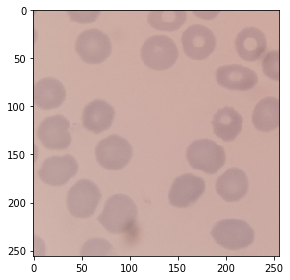

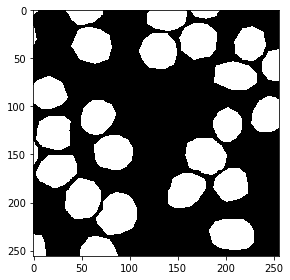

In [12]:
# Check if training data looks all right
ix = random.randint(0, len(img_train))
print(ix)
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [13]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)


In [14]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
_______________________________________________________________________________________

In [15]:
if not os.path.isdir("../logs/fit/"):
    os.makedirs("../logs/fit/")
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
results = model.fit(img_train, mask_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer, tensorboard_callback])

Epoch 1/100
  1/140 [..............................] - ETA: 0s - loss: 0.8083 - accuracy: 0.5145WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
140/140 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9392
Epoch 00001: val_loss improved from inf to 0.88171, saving model to model_unet_checkpoint.h5
140/140 [==============================] - 29s 210ms/step - loss: 0.1867 - accuracy: 0.9392 - val_loss: 0.8817 - val_accuracy: 0.7689
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9624
Epoch 00002: val_loss improved from 0.88171 to 0.63405, saving model to model_unet_checkpoint.h5
140/140 [==============================] - 28s 203ms/step - loss: 0.1062 - accuracy: 0.9624 - val_loss: 0.6341 - val_acc

140/140 [==============================] - 28s 200ms/step - loss: 0.0487 - accuracy: 0.9793 - val_loss: 0.0825 - val_accuracy: 0.9690
Epoch 27/100
140/140 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9793
Epoch 00027: val_loss did not improve from 0.07250
140/140 [==============================] - 27s 196ms/step - loss: 0.0485 - accuracy: 0.9793 - val_loss: 0.0919 - val_accuracy: 0.9705
Epoch 00027: early stopping



# Make predictions

In [18]:
# Predict on train, val and test
model = load_model('model_unet_checkpoint.h5')
preds_train = model.predict(img_train[:int(img_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(img_train[int(img_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(img_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


5/5 [==============================] - 1s 184ms/step


In [19]:
# Create list of upsampled test masks
# This is only required when original pictures are larger or smaller
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

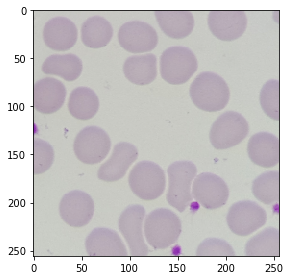

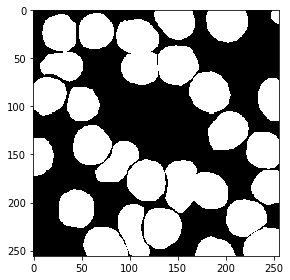

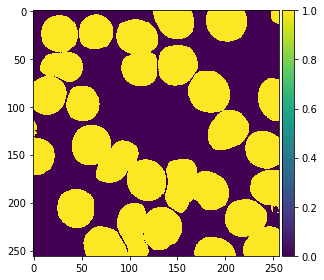

In [20]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

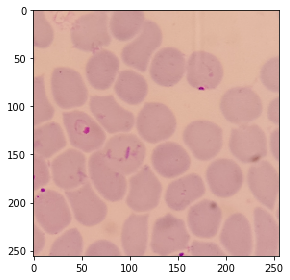

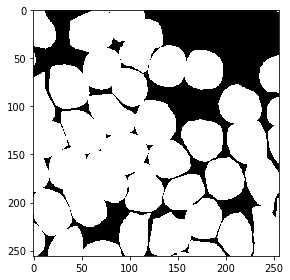

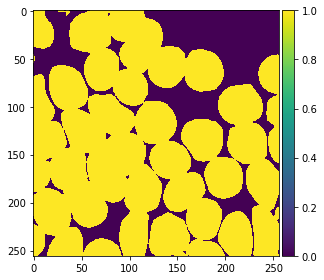

In [21]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(img_train[int(img_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(mask_train[int(mask_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

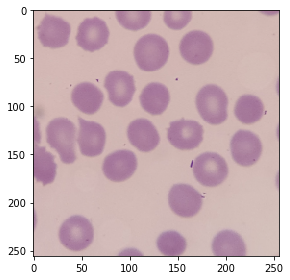

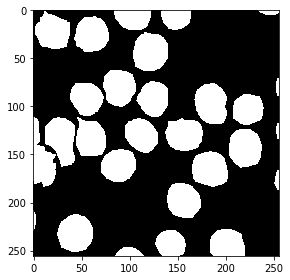

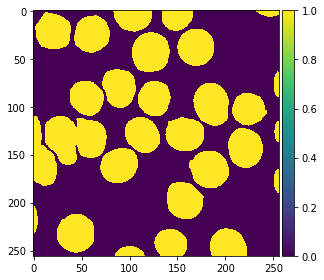

In [26]:
# Perform check on test set
ix = random.randint(0, len(preds_test_t))
imshow(img_test[ix])
plt.show()
imshow(np.squeeze(mask_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()


# Connected Components

In [43]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
#     # Showing Original Image
#     plt.imshow(mask)
#     plt.axis("off")
#     plt.title("Orginal Image")
#     plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

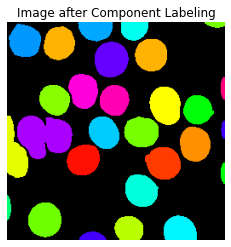

In [44]:
connected_component_label(np.squeeze(preds_test_t[ix]))